In [5]:
import numpy as np

In [4]:
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

In [7]:
data_dir = 'Dataset'

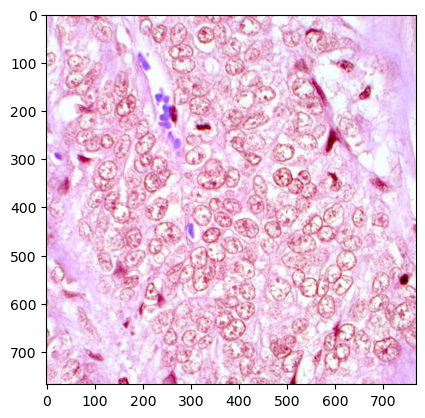

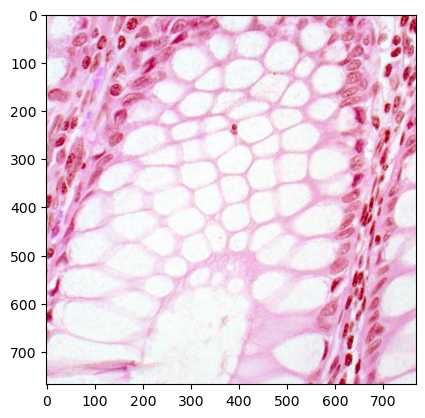

In [13]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        img = cv2.imread(image_path)
        # imghdr module determines the type of image contained in a file or byte stream
        tip = imghdr.what(image_path)
        plt.imshow(img)
        plt.show()
        break

### Load Data

In [8]:
data = tf.keras.preprocessing.image_dataset_from_directory('Dataset')

Found 10000 files belonging to 2 classes.


In [101]:
class_labels = data.class_names
class_labels

['colon_aca', 'colon_n']

In [19]:
data

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [9]:
data_iterator = data.as_numpy_iterator()

In [20]:
data_iterator

In [67]:
batch = data_iterator.next()

In [68]:
batch

(array([[[[223., 193., 247.],
          [210., 184., 232.],
          [163., 141., 214.],
          ...,
          [253., 244., 245.],
          [254., 248., 248.],
          [253., 247., 247.]],
 
         [[203., 172., 239.],
          [169., 144., 201.],
          [159., 136., 214.],
          ...,
          [252., 243., 246.],
          [250., 241., 244.],
          [249., 240., 243.]],
 
         [[189., 161., 236.],
          [158., 134., 196.],
          [141., 116., 199.],
          ...,
          [245., 236., 239.],
          [244., 233., 237.],
          [248., 237., 241.]],
 
         ...,
 
         [[136., 138., 212.],
          [200., 191., 246.],
          [225., 201., 235.],
          ...,
          [243., 218., 240.],
          [244., 223., 242.],
          [242., 230., 230.]],
 
         [[153., 145., 220.],
          [194., 174., 233.],
          [234., 206., 244.],
          ...,
          [244., 218., 243.],
          [240., 218., 231.],
          [242., 227., 220.

In [70]:
len(batch)

2

The number 2 indicates the image representation and the image label.

In [73]:
# Images represented as numpy arrays
# Class 0: Colon adenocarcinoma
# Class 1: Colon benign tissue
batch[0].shape

(32, 256, 256, 3)

In [72]:
batch[1] 

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

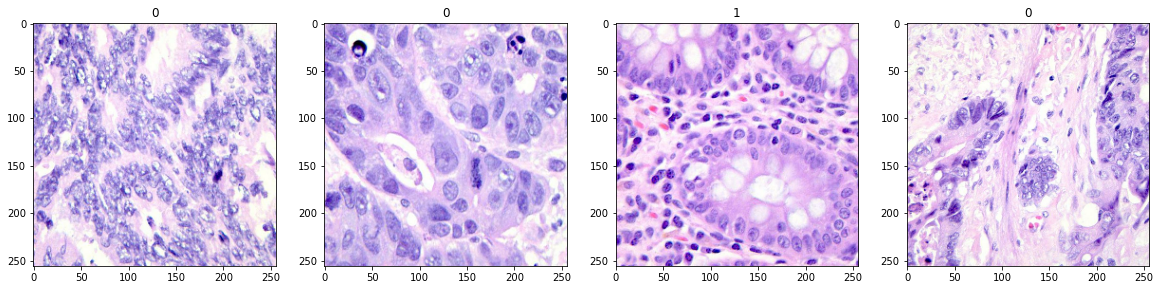

In [69]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocessing

Sclaing our image values to between 0 and 1 instead of zero to 255 helps our deep learning model generalize faster and produces better results.

We are going to split our data into ``training``, ``testing`` and ``validation`` partitions to ensure that we don't overfit.

#### Scale Data

In [10]:
data = data.map(lambda x,y: (x / 255, y))

In [11]:
scaled_iterator = data.as_numpy_iterator()

In [12]:
batch = scaled_iterator.next()

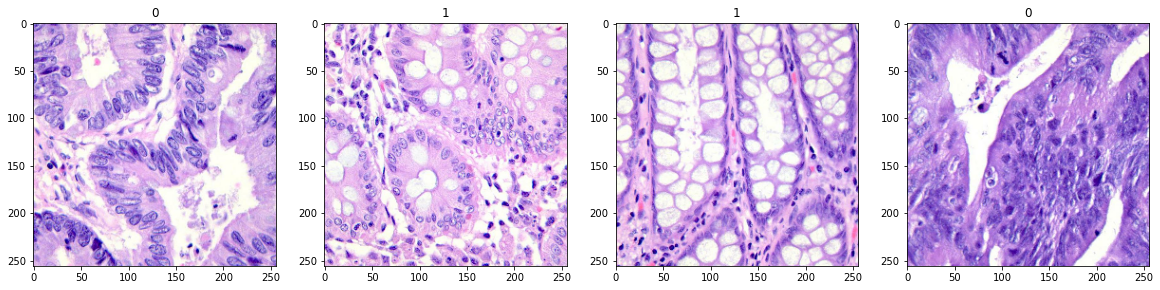

In [105]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

#### Split Data

In [107]:
len(data)

313

It indicates we have 313 batches

In [13]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

In [14]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### Build Deep Learning Model

#### Build Deep Learning Model

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [111]:
model = Sequential()

In [113]:
# The Conv2D layer's gonna have 16 filters.
# It scans over an image and tries to condese or extract the relevant
# information inside of that image to make an output classification
# (3,3) is the size of the filter and 1 is the stride 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [116]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [117]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        4

#### Train

In [121]:
logdir = 'logs'

In [122]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [123]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
219/219 [==============================] - 410s 2s/step - loss: 0.6241 - accuracy: 0.6304 - val_loss: 0.3484 - val_accuracy: 0.8553
Epoch 2/20
219/219 [==============================] - 342s 2s/step - loss: 0.3038 - accuracy: 0.8717 - val_loss: 0.2297 - val_accuracy: 0.9133
Epoch 3/20
219/219 [==============================] - 298s 1s/step - loss: 0.1952 - accuracy: 0.9238 - val_loss: 0.3976 - val_accuracy: 0.8090
Epoch 4/20
219/219 [==============================] - 513s 2s/step - loss: 0.2036 - accuracy: 0.9188 - val_loss: 0.1010 - val_accuracy: 0.9602
Epoch 5/20
219/219 [==============================] - 331s 2s/step - loss: 0.1424 - accuracy: 0.9456 - val_loss: 0.0988 - val_accuracy: 0.9677
Epoch 6/20
219/219 [==============================] - 287s 1s/step - loss: 0.0704 - accuracy: 0.9770 - val_loss: 0.1021 - val_accuracy: 0.9632
Epoch 7/20
219/219 [==============================] - 1483s 7s/step - loss: 0.0906 - accuracy: 0.9670 - val_loss: 0.0551 - val_accuracy: 0.981

#### Plot Performance

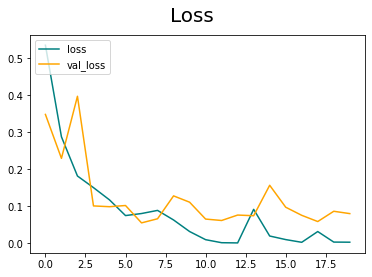

In [124]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')

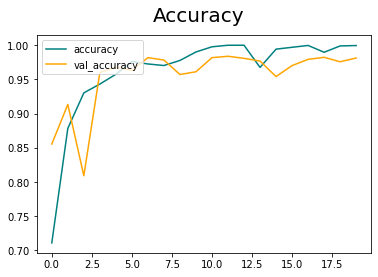

In [125]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")

## Evaluate Performance

In [25]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [26]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
matrix = []

In [33]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = new_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    confusion_matrix = tf.math.confusion_matrix(y, yhat)
    matrix.append(confusion_matrix)
    print(confusion_matrix)

tf.Tensor(
[[16  0]
 [13  3]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[13  0]
 [12  7]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[17  0]
 [ 7  8]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[15  0]
 [10  7]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[16  0]
 [ 6 10]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[19  0]
 [ 7  6]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[16  0]
 [10  6]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[12  0]
 [15  5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[18  0]
 [10  4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[17  0]
 [11  4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[19  0]
 [ 6  7]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[18  0]
 [ 9  5]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[15  0]
 [11  6]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[16  0]
 [13  3]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[18  0]
 [12  2]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[19  0]
 [ 9  4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[19  0]
 [ 6  7]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1

In [130]:
print(f'Precisoin:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precisoin:0.9712643623352051, Recall:0.9921721816062927, Accuracy:0.9808467626571655


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
tp = 0
for i in matrix:
    tp += i.numpy()[0][0]

In [45]:
fp = 0
for i in matrix:
    fp += i.numpy()[0][1]

In [46]:
fn = 0
for i in matrix:
    fn += i.numpy()[1][0]

In [47]:
tn = 0
for i in matrix:
    tn += i.numpy()[1][1]

In [53]:
m = [[tp, fp],
     [fn, tn]]

In [61]:
marray = np.array(m)

In [62]:
marray

array([[514,   0],
       [313, 165]])

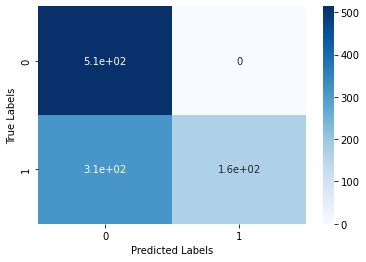

In [63]:
sns.heatmap(marray, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)

## Test

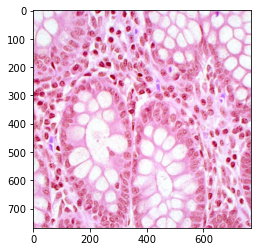

In [14]:
img = cv2.imread('test3.jpeg')
plt.imshow(img)

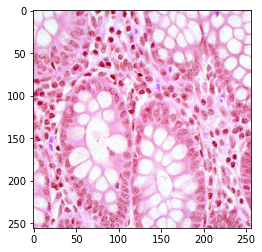

In [15]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))

In [153]:
yhat = model.predict(np.expand_dims(resize / 255, 0))

In [154]:
yhat

array([[0.7150351]], dtype=float32)

In [156]:
if yhat > 0.5:
    print(f'Predicted class is benign.')
else:
    print(f'Predicted class is malignant.')

Predicted class is benign.


## Save The Model

In [2]:
from tensorflow.keras.models import load_model

In [8]:
import numpy as np
import os
import cv2

In [158]:
model.save(os.path.join('models', 'coloncancerclassification.h5'))

In [22]:
new_model = load_model(os.path.join('models', 'coloncancerclassification.h5'))

In [16]:
new_model.predict(np.expand_dims(resize / 255, 0))

array([[0.7150351]], dtype=float32)

In [10]:
from keras.utils.vis_utils import plot_model

In [20]:
plot_model(new_model, to_file='cnn_model.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
